<a href="https://colab.research.google.com/github/Arindam75/Audio-Resnet/blob/main/Resnet_RELU_ESC_Sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Add,Dense,Flatten,Dropout,Input,Activation,MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import initializers
import pandas as pd
from tensorflow.keras.regularizers import l2

import numpy as np
import os
import datetime
import pandas as pd

In [ ]:
path='/content/drive/My Drive/'
path

'/content/drive/My Drive/'

In [ ]:
data = np.load(path+'/Training Data 200.npz')
X_train=data['name1']
y_train=data['name2']

data = np.load(path+'/Validation Data 200.npz')
X_val=data['name1']
y_val=data['name2']

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(92274, 13, 9)
(92274, 10)
(71, 13, 9)
(71, 10)


In [ ]:
def generator(X1,y1,batch_size):
    while True:
        samples=X1.shape[0]
        batches=samples//batch_size

        s = np.arange(X1.shape[0])
        np.random.shuffle(s)
        X=X1[s]
        y=y1[s]
        for batch in range(0,batches):
            start=batch*batch_size
            stop=batch*batch_size+batch_size
            reshape_x=np.zeros([batch_size, 32, 32, 3])
            reshape_x[::,0:13:,0:9:,0]=X[start:stop,::,::]
            
            yield reshape_x,y[start:stop]
            
        last_batch=X[stop:].shape[0]
        reshape_x=np.zeros([last_batch, 32, 32, 3])
        reshape_x[::,0:13:,0:9:,0]=X[stop:,::,::]

        yield reshape_x,y[stop:]

In [ ]:
train_batch_size=32
val_batch_size=32
num_epochs=150

num_train_sequences=X_train.shape[0]
num_val_sequences=X_val.shape[0]

train_generator = generator(X_train, y_train,train_batch_size)
val_generator = generator(X_val, y_val, val_batch_size)

if (num_train_sequences%train_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/train_batch_size)
else:
    steps_per_epoch = (num_train_sequences//train_batch_size) + 1

if (num_val_sequences%val_batch_size) == 0:
    validation_steps = int(num_val_sequences/val_batch_size)
else:
    validation_steps = (num_val_sequences//val_batch_size) + 1

In [ ]:
x,y=next(val_generator)
x.shape

(32, 32, 32, 3)

In [ ]:
my_model = resnet50.ResNet50(include_top=False, input_shape=(32,32,3))


flat = Flatten()(my_model.layers[-114].output)
class1 = Dense(1024, activation='relu',kernel_initializer='glorot_normal')(flat)
output = Dense(10, activation='softmax')(class1)

model = Model(inputs=my_model.inputs, outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

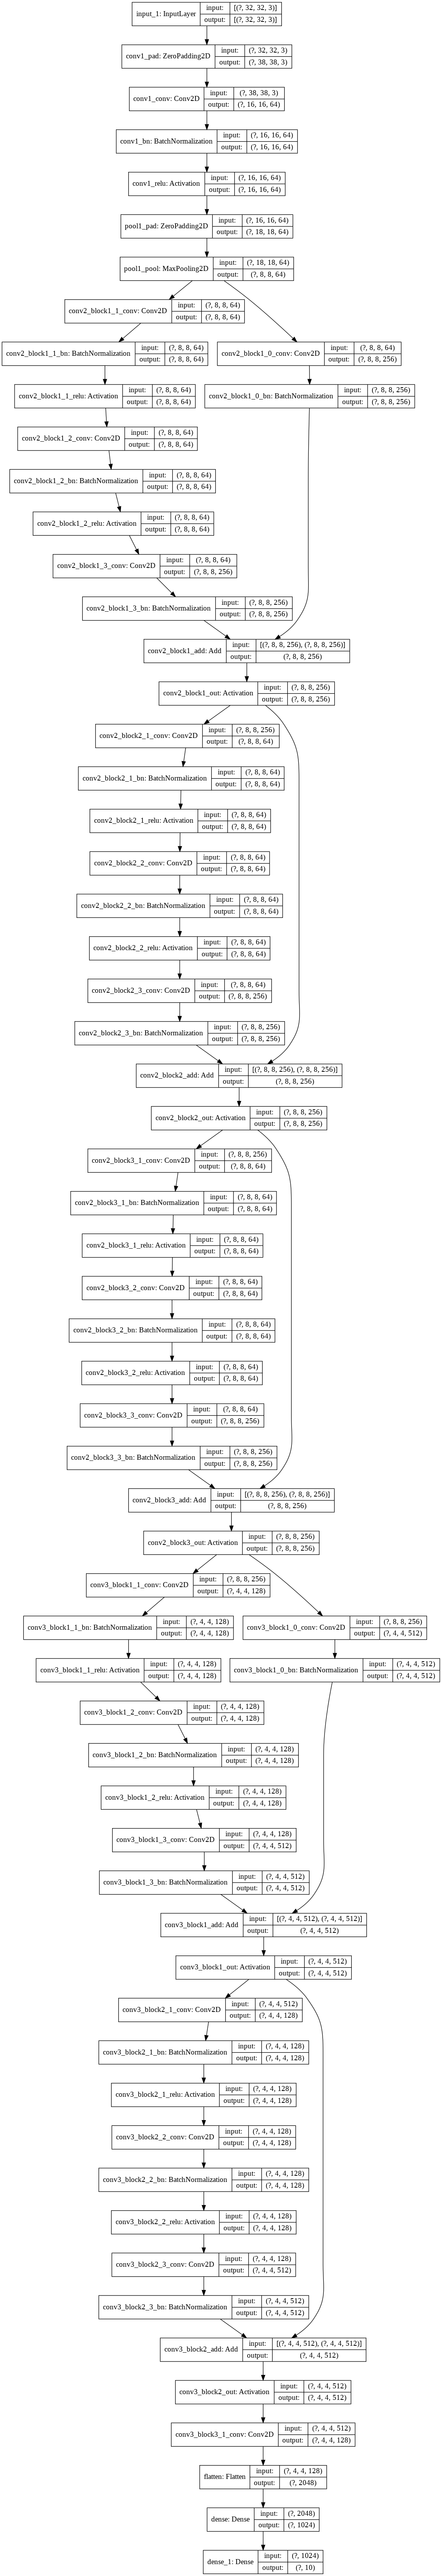

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name =path+'/ESC 200_4' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

In [ ]:
filepath

'/content/drive/My Drive//ESC 200_4/model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

In [ ]:
#checkpoint_path=path+'/ESC 200/model-00115-0.03802-9.61666-0.99419-0.73239.h5'
#model = load_model(checkpoint_path)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
2884/2884 [==============================] - ETA: 0s - loss: 0.6325 - acc: 0.7867
Epoch 00001: val_acc improved from -inf to 0.35211, saving model to /content/drive/My Drive//ESC 200_4/model-00001-0.63249-3.45531-0.78668-0.35211.h5
2884/2884 [==============================] - 25s 9ms/step - loss: 0.6325 - acc: 0.7867 - val_loss: 3.4553 - val_acc: 0.3521
Epoch 2/150
2884/2884 [==============================] - ETA: 0s - loss: 0.3074 - acc: 0.8958
Epoch 00002: val_acc improved from 0.35211 to 0.53521, saving model to /content/drive/My Drive//ESC 200_4/model-00002-0.30742-3.18395-0.89581-0.53521.h5
2884/2884 [==============================] - 25s 9ms/step - loss: 0.3074 - acc: 0.8958 - val_loss: 3.1840 - val_acc: 0.5352
Epoch 3/150
2883/2884 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9244
Epoch 00003: val_acc improved from 0.53521 to 0.63380, saving model to /content/drive/My Dr

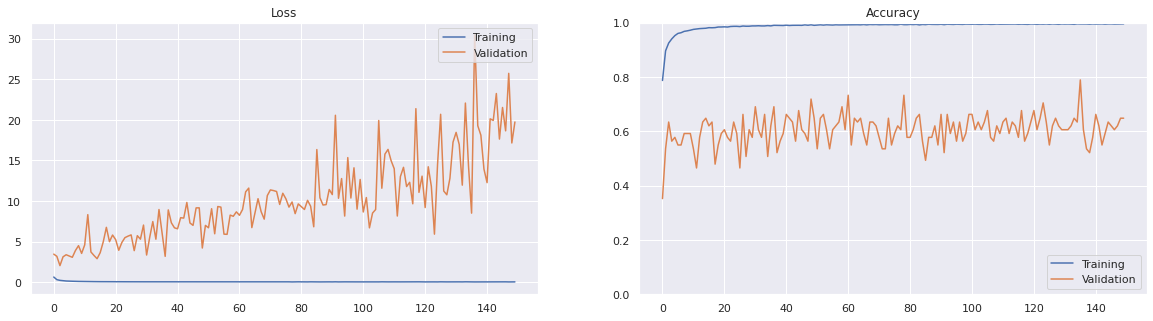

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figwidth(20)
fig1.set_figheight(5)

#fig1.suptitle('Model 3 Conv 3D Performance No Pre Processing')
ax1.plot(history.history['loss'],label='Training')
ax1.plot(history.history['val_loss'],label='Validation')
ax1.set_title('Loss')
#ax1.set_ylim(0, 3)
ax1.legend(loc="upper right")

ax2.plot(history.history['acc'],label='Training')
ax2.plot(history.history['val_acc'],label='Validation')
ax2.set_title('Accuracy')
ax2.set_ylim(0.0, 1)
ax2.legend(loc="lower right")

In [ ]:
relu_esc_100=pd.DataFrame(list(zip(history.history['acc'],history.history['val_acc'],
history.history['loss'],history.history['val_loss'])),columns =['Acc1', 'Val_Acc1','Loss1','Val_loss1'])

In [ ]:
relu_esc_100.to_csv(path+'/ESC 200_4//relu_esc_100.csv')